In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import os
import datetime

c:\Users\pawpo\miniconda3\envs\p_paint\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
(train, test), info = tfds.load("emnist/digits", as_supervised=True, split=["train", "test"], with_info=True)

In [5]:
info.description

'The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset.\n\nNote: Like the original EMNIST data, images provided here are inverted horizontally and rotated 90 anti-clockwise. You can use `tf.transpose` within `ds.map` to convert the images to a human-friendlier format.'

In [6]:
info.features["label"].names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [7]:
print(f"Train set size is {train.__len__()}.")
print(f"Test set size is {test.__len__()}.")

Train set size is 240000.
Test set size is 40000.


In [8]:
@tf.function
def map_labels(features, label):
    return features, tf.one_hot(label, 10)

def decode_label(one_hots):
    return int(tf.argmax(one_hots, axis=0))

In [9]:
print(map_labels((),9))

((), <tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)>)


In [10]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32

train_set = train.shuffle(1000).map(map_labels).repeat().batch(BATCH_SIZE).prefetch(AUTOTUNE)
validation_set = test.batch(BATCH_SIZE).map(map_labels).prefetch(AUTOTUNE) # use test_set as validation_set

STEPS_PER_EPOCH = train.__len__() / BATCH_SIZE

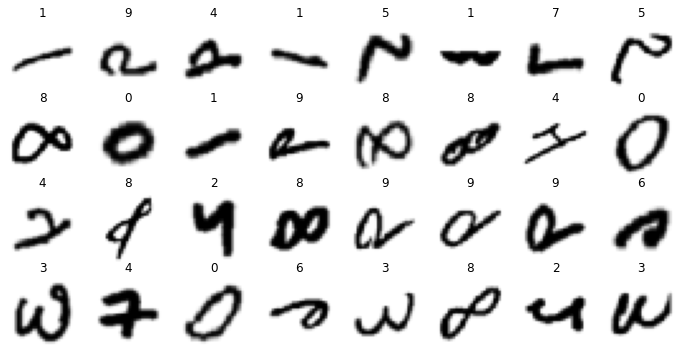

In [11]:
i = 1
plt.figure(figsize=(12, 6))
for samples_x, samples_y in train_set.take(1):
    for sample_x, sample_y in zip(samples_x, samples_y):
        plt.subplot(4, 8, i)
        plt.imshow(sample_x.numpy(), cmap="binary")
        plt.title(decode_label(sample_y.numpy()))
        plt.axis("off")
        i += 1
plt.show()

In [12]:
model = keras.models.Sequential([
    keras.layers.Input(shape=[28, 28, 1]),
    keras.layers.Conv2D(32, kernel_size=5, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(64, kernel_size=5, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(10, activation="softmax"),
])

In [13]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

In [15]:
MODEL_FILE = "model.h5"

log_dir = os.path.join(os.curdir, "logs", datetime.datetime.now().strftime("%Y-%m-%d_%H.%M.%S"))
tensorbord_cb = keras.callbacks.TensorBoard(log_dir=log_dir, write_steps_per_second=True, histogram_freq=1, write_images=True, update_freq=10000)
earlystop_cb = keras.callbacks.EarlyStopping(patience=5)
save_cb = keras.callbacks.ModelCheckpoint(MODEL_FILE, save_best_only=True)

In [16]:
with tf.device('GPU:0'): # use gpu
    history = model.fit(train_set, validation_data=validation_set, epochs=100, steps_per_epoch=STEPS_PER_EPOCH, callbacks=[tensorbord_cb, earlystop_cb, save_cb]) # 100 epochs because it will stop earlier by callback

Epoch 1/100
7500/7500 [==============================] - 65s 8ms/step - loss: 0.3089 - accuracy: 0.9228 - val_loss: 0.0524 - val_accuracy: 0.9854
Epoch 2/100
7500/7500 [==============================] - 55s 7ms/step - loss: 0.1258 - accuracy: 0.9682 - val_loss: 0.0396 - val_accuracy: 0.9889
Epoch 3/100
7500/7500 [==============================] - 52s 7ms/step - loss: 0.1156 - accuracy: 0.9714 - val_loss: 0.0355 - val_accuracy: 0.9904
Epoch 4/100
7500/7500 [==============================] - 53s 7ms/step - loss: 0.1120 - accuracy: 0.9732 - val_loss: 0.0395 - val_accuracy: 0.9903
Epoch 5/100
7500/7500 [==============================] - 53s 7ms/step - loss: 0.1110 - accuracy: 0.9740 - val_loss: 0.0442 - val_accuracy: 0.9887
Epoch 6/100
7500/7500 [==============================] - 52s 7ms/step - loss: 0.1112 - accuracy: 0.9750 - val_loss: 0.0409 - val_accuracy: 0.9901
Epoch 7/100
7500/7500 [==============================] - 53s 7ms/step - loss: 0.1151 - accuracy: 0.9744 - val_loss: 0.0413 -

In [17]:
%load_ext tensorboard

In [18]:
model.save("final_model.h5") # save last model as well

In [19]:
model.evaluate(validation_set)

1250/1250 [==============================] - 5s 4ms/step - loss: 0.0483 - accuracy: 0.9868


[0.04834761470556259, 0.9867500066757202]

In [20]:
best_model = keras.models.load_model("model.h5")

In [21]:
best_model.evaluate(validation_set)

1250/1250 [==============================] - 5s 4ms/step - loss: 0.0355 - accuracy: 0.9904


[0.035483360290527344, 0.9903500080108643]